In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import os
import random
from sklearn.metrics import confusion_matrix, classification_report
import cv2

In [2]:
DATADIR = r".\DL_TRAIN_DATA\Images"
CATEGORIES = ["Books2", "Boxes2", "Cups2"]
IMG_SIZE = 100

In [3]:
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def zoom(img, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken]
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

def horizontal_flip(img):
    return cv2.flip(img, random.choice([0, 1]))
    
def brightness(img, low, high):
    value = random.uniform(low, high)
    grey_new = np.where((255 - img) < value,255,img+value)
    return grey_new

def rand_transf(img):
    img = rotation(img, 20)
    img = zoom(img, 0.7)
    img = horizontal_flip(img)
    img = brightness(img, 0, 10)
    return img

def make_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            #try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            train_data.append([resized_img_array, class_num])

            trans1_img_array = rand_transf(resized_img_array)
            train_data.append([trans1_img_array, class_num])

            trans2_img_array = rand_transf(resized_img_array)
            train_data.append([trans2_img_array, class_num])
            
            trans3_img_array = rand_transf(resized_img_array)
            train_data.append([trans3_img_array, class_num])
            
    
            #    print(img)
            #except Exception as e: 
            #    print(e)

In [4]:
train_data = []
make_train_data()
print(len(train_data))

2612


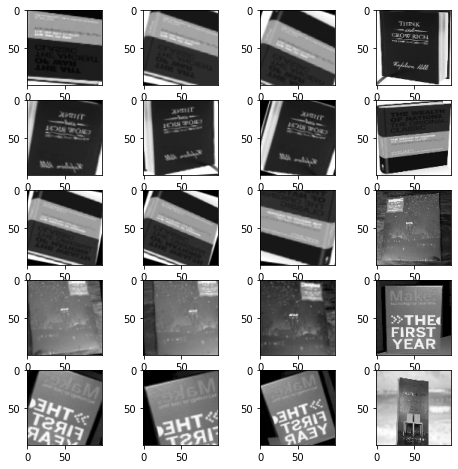

In [5]:
#plt.imshow(train_data[5][0], cmap='gray')

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = train_data[i][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
random.shuffle(train_data)

In [7]:
X = []
y = []

for features, label in train_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X = X/255.0
y = np.array(y)

In [8]:
class tooGood(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("accuracy") > 0.9):
            print("\n Desired accuracy reached; training ended.")
            self.model.stop_training = True

In [9]:
#callbacks = tooGood()

In [10]:
DATADIR_TEST = r".\DL_DATA"
CATEGORIES_TEST = ["Books", "Boxes", "Cups"]

In [11]:
def make_test_data():
    for category_test in CATEGORIES_TEST:
        path_test = os.path.join(DATADIR_TEST, category_test)
        class_num_test = CATEGORIES_TEST.index(category_test)
        for img_test in os.listdir(path_test):
            try:
                img_array_test = cv2.imread(os.path.join(path_test, img_test), cv2.IMREAD_GRAYSCALE)
                resized_img_array_test = cv2.resize(img_array_test, (IMG_SIZE, IMG_SIZE))
                test_data.append([resized_img_array_test, class_num_test])
            except Exception as e: 
                pass

In [12]:
test_data = []
make_test_data()
print(len(test_data))

1012


In [13]:
random.shuffle(test_data)

In [14]:
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test/255.0
y_test = np.array(y_test)

print(len(X_test))
print(len(y_test))

1012
1012


In [15]:

cnn_model = models.Sequential([
    
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", input_shape = X.shape[1:]),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.25),
    layers.Dense(32, activation = "relu"),
    layers.Dense(3, activation = "softmax")
    
    #Maybe add another Dense 1 and activation? Maybe activation sigmoid? 
    
])

"""
cnn_model = models.Sequential([
    layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=X.shape[1:]),
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPool2D(strides=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])
"""

"\ncnn_model = models.Sequential([\n    layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=X.shape[1:]),\n    layers.Conv2D(32, (5,5), padding='same', activation='relu'),\n    layers.MaxPool2D(),\n    layers.Dropout(0.25),\n    layers.Conv2D(64, (3,3), padding='same', activation='relu'),\n    layers.Conv2D(64, (3,3), padding='same', activation='relu'),\n    layers.MaxPool2D(strides=(2,2)),\n    layers.Dropout(0.25),\n    layers.Flatten(),\n    layers.Dense(128, activation='relu'),\n    layers.Dropout(0.5),\n    layers.Dense(3, activation='softmax')\n])\n"

In [16]:
cnn_model.compile(optimizer = "adam", 
             loss = "sparse_categorical_crossentropy", 
            #Maybe do binary_crossentropy? if it's greyscale... 
             metrics = ["accuracy"])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
cnn_model.fit(X, y, batch_size = 128, epochs = 10, validation_data=(X_test,y_test))#, callbacks = [callback])

Epoch 1/10
21/21 [==============================] - 25s 1s/step - loss: 1.0866 - accuracy: 0.3962 - val_loss: 1.0050 - val_accuracy: 0.7204
Epoch 2/10
21/21 [==============================] - 23s 1s/step - loss: 1.0173 - accuracy: 0.5138 - val_loss: 0.9508 - val_accuracy: 0.6927
Epoch 3/10
21/21 [==============================] - 25s 1s/step - loss: 0.9287 - accuracy: 0.5773 - val_loss: 0.8808 - val_accuracy: 0.6947
Epoch 4/10
21/21 [==============================] - 25s 1s/step - loss: 0.8485 - accuracy: 0.6275 - val_loss: 0.8630 - val_accuracy: 0.6285
Epoch 5/10
21/21 [==============================] - 27s 1s/step - loss: 0.7705 - accuracy: 0.6746 - val_loss: 0.8057 - val_accuracy: 0.6314
Epoch 6/10
21/21 [==============================] - 28s 1s/step - loss: 0.6981 - accuracy: 0.7159 - val_loss: 0.8083 - val_accuracy: 0.7115
Epoch 7/10
21/21 [==============================] - 28s 1s/step - loss: 0.6195 - accuracy: 0.7596 - val_loss: 0.9216 - val_accuracy: 0.6640
Epoch 8/10
21/21 [==

In [18]:
cnn_model.evaluate(X_test,y_test)

32/32 [==============================] - 3s 86ms/step - loss: 0.8955 - accuracy: 0.6789


[0.8954666256904602, 0.6788537502288818]

In [19]:
y_pred = cnn_model.predict(X_test)
y_pred_labels = [np.argmax(elem) for elem in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.96      0.76       438
           1       0.84      0.77      0.80       283
           2       0.57      0.16      0.25       291

    accuracy                           0.68      1012
   macro avg       0.68      0.63      0.61      1012
weighted avg       0.67      0.68      0.63      1012



In [20]:
tf.math.confusion_matrix(
    y_test,
    y_pred_labels,
    num_classes=3,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[422,   3,  13],
       [ 42, 218,  23],
       [205,  39,  47]])>

In [21]:
a = y_test == y_pred_labels
a = list(a.ravel())
print(a.count(False), a.count(True))

325 687


In [22]:
cnn_model.save_weights('./savedmodel/model')

In [23]:
print(y_pred)

[[0.16633788 0.49580348 0.3378587 ]
 [0.6318313  0.2003314  0.16783723]
 [0.97517926 0.00729093 0.01752985]
 ...
 [0.5803861  0.35586524 0.06374873]
 [0.13189302 0.7328514  0.13525563]
 [0.99520075 0.00366293 0.00113625]]
